In [1]:
from SimPEG import *
from simpegEM1D import (
    Utils1D, get_vertical_discretization_time, 
    set_mesh_1d, skytem_HM_2015
)
from simpegEM1D.simulation import EM1DTMSimulation
from simpegEM1D.survey import EM1DSurveyTD
from simpegEM1D import EM1DAnalytics
import numpy as np
from simpegEM1D import skytem_HM_2015
from simpegEM1D.DigFilter import setFrequency, transFilt
from scipy.constants import mu_0
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
time = np.logspace(-5, -2, 31)
# three layers
hz = np.array([10, 10, 10])
sigma_half = 0.1

# half-space conductivity
sigma = np.ones(hz.size) * sigma_half
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
# offset b/w VMD source and Bz receiver
offset = np.array([10.])

LocSigZ = -mesh1D.gridCC
TDsurvey = EM1DSurveyTD(
    rx_location = np.array([0., 0., 100.]),
    src_location = np.array([0., 0., 100.]),
    topo = np.r_[0., 0., 100.],
    depth = depth,
    rx_type = 'Bz',
    wave_type = 'stepoff',
    src_type = 'VMD',
    offset=offset,
    time = time,
)
imap = maps.IdentityMap(mesh1D)
sim = EM1DTMSimulation(mesh1D, survey=TDsurvey, sigmaMap=imap, verbose=False)
bz = sim.dpred(sigma)
print(np.shape(bz))
print(bz)

(31,)
[8.08568701e-12 6.05308651e-12 4.47918289e-12 3.28434137e-12
 2.39082145e-12 1.73041915e-12 1.24673427e-12 8.95008883e-13
 6.40665731e-13 4.57562169e-13 3.26195179e-13 2.32213450e-13
 1.65119120e-13 1.17304714e-13 8.32766395e-14 5.90851502e-14
 4.19025878e-14 2.97060668e-14 2.10535441e-14 1.49178592e-14
 1.05684045e-14 7.48600648e-15 5.30202123e-15 3.75485979e-15
 2.65897727e-15 1.88283018e-15 1.33317778e-15 9.43952283e-16
 6.68343667e-16 4.73196098e-16 3.35023064e-16]


In [3]:
def bz_analytic_solution(r, t, sigma):
    """
    r: offset bewteen VMD soure and Bz receiver (m)
    t: measured times
    sigma: conductivity of the half-space earth
    """
    wt, tbase, omega_int = setFrequency(t)
    hz = EM1DAnalytics.Hzanal(sigma, omega_int/2/np.pi, r, 'secondary')
    # Treatment for inaccuracy in analytic solutions
    ind = omega_int < 0.2
    hz[ind] = 0.
    hzTD, f0 = transFilt(hz, wt, tbase, omega_int, t)
    return hzTD*mu_0

In [4]:
bz_analytic = bz_analytic_solution(offset, time, sigma_half)
print(np.shape(bz_analytic))
print(bz_analytic)

(31,)
[8.09316857e-12 6.06698620e-12 4.49551685e-12 3.29172016e-12
 2.39503887e-12 1.73740816e-12 1.25093533e-12 8.95539752e-13
 6.43131939e-13 4.59430578e-13 3.26462306e-13 2.32942155e-13
 1.65831926e-13 1.17543076e-13 8.34320390e-14 5.93153625e-14
 4.20071771e-14 2.96975019e-14 2.11024543e-14 1.49397731e-14
 1.05327498e-14 7.47226130e-15 5.28550866e-15 3.72160909e-15
 2.62520779e-15 1.85067287e-15 1.29653552e-15 9.04398964e-16
 6.30339448e-16 4.34161312e-16 2.94066345e-16]


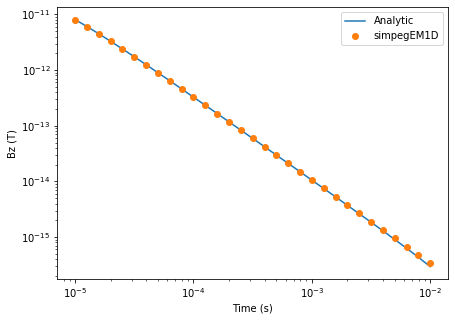

In [6]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.loglog(TDsurvey.time, bz_analytic, '-')
axes.loglog(TDsurvey.time, bz, 'o')
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel('Time (s)')
axes.set_ylabel('Bz (T)')
axes.legend(("Analytic", "simpegEM1D"))